In [1]:
cd /Users/frankcorrigan/Repositories/Udacity/Machine-Learning/final_project/submission/

/Users/frankcorrigan/Repositories/Udacity/Machine-Learning/final_project/submission


In [2]:
import pickle
data_dict = pickle.load(open("final_project_dataset.pkl", "r") )

In [3]:
import pandas as pd
import numpy as np
odata = pd.DataFrame.from_dict(data_dict, orient='index')

In [4]:
odata = odata.replace('NaN', 0, regex=True)

In [5]:
# pdata.loc['BELFER ROBERT']
odata.loc['BELFER ROBERT', 'expenses'] = 3285.0
odata.loc['BELFER ROBERT', 'deferral_payments'] = 0.0
odata.loc['BELFER ROBERT', 'deferred_income'] = -102500.0
odata.loc['BELFER ROBERT', 'director_fees'] = 102500.0
odata.loc['BELFER ROBERT', 'total_payments'] = 3285.0
# pdata.loc['BHATNAGAR SANJAY']
odata.loc['BHATNAGAR SANJAY', 'expenses'] = 137864.0
odata.loc['BHATNAGAR SANJAY', 'total_payments'] = 137864.0
odata.loc['BHATNAGAR SANJAY', 'other'] = 0.0
odata.loc['BHATNAGAR SANJAY', 'director_fees'] = 0.0

In [6]:
odata = odata.drop('email_address', 1)

In [7]:
odata = odata[odata.index != 'TOTAL']

In [8]:
odata = odata.replace(np.nan, 0, regex=True)
odata = odata.replace(np.inf, 0, regex=True)
odata = odata.replace(-np.inf, 0, regex=True)
odict = odata.T.to_dict()

In [9]:
import sys
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

In [11]:
# Declare original feature list
features_list = ['poi']
for el in odata.columns:
    if el not in ['poi']:
        features_list.append(el)

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

models = {'knn'       : {'model' : KNeighborsClassifier(),
                         'pipe'  : Pipeline([['sc', StandardScaler()],
                                             ['clf', KNeighborsClassifier()]]),
                         'params': [{'clf__weights': ['uniform', 'distance'],
                                     'clf__n_neighbors': range(2,6)}]},
          'lr'        : {'model' : LogisticRegression(),
                         'pipe'  : Pipeline([['sc', StandardScaler()],
                                             ['clf', LogisticRegression()]]),
                         'params': [{'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]},
          'linSVC'    : {'model' : LinearSVC(),
                         'pipe'  : Pipeline([['sc', StandardScaler()],
                                             ['clf', LinearSVC()]]),
                         'params': [{'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]},
          'kernelSVC' : {'model' : SVC(),
                         'pipe'  : Pipeline([['sc', StandardScaler()],
                                             ['clf', SVC()]]),
                         'params': [{'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                                     'clf__gamma': [0.0001, 0.001, 0.01, 0.1, 0.0, 1.0]}]},
          'decTree'   : {'model' : DecisionTreeClassifier(),
                         'pipe'  : Pipeline([['sc', MinMaxScaler()],
                                             ['clf', DecisionTreeClassifier()]]),
                         'params': [{'clf__min_samples_split': [2, 10, 20, 30, 40, 50, 60],
                                     'clf__criterion': ['entropy', 'gini']}]}          
          }
#                'pca__whiten': [False,True],
#                'pca__n_components': pca_range

In [14]:
def getBest(featureList):
    # Prep dataset
    my_dataset = odict.copy()
    data = featureFormat(my_dataset, featureList, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    # Scale the data
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    # Run SelectKBest
    x_new = SelectKBest(f_classif, k='all')
    x_new.fit_transform(features, labels)
    # Order best elements into a featurelist
    best = []
    for i in range(len(x_new.scores_)):
        best.append((featureList[i+1], x_new.scores_[i]))

    best = sorted(best,key=lambda x: x[1], reverse=True)

    bestList = ['poi']
    for el in best:
        bestList.append(el[0])
        
    return bestList

In [19]:
from sklearn.cross_validation import cross_val_score
def selectFeatures(pipe, featList):
    
    bestList = getBest(featList)
    
    scoresArray = []
    f_range = range(1, len(bestList)+1)
    
    for i in f_range:
        # new features gives us up to i new features each iteration
        new_features = bestList[0:i+1]
        my_dataset = odict.copy()
        data = featureFormat(my_dataset, new_features, sort_keys = True)
        labels, features = targetFeatureSplit(data)
        scores = cross_val_score(pipe,
                                 X = features,
                                 y = labels,
                                 cv = StratifiedShuffleSplit(labels, n_iter = 5, random_state=42),
                                 scoring = 'f1') 
        scoresArray.append(scores.mean())
    
    bestScore = scoresArray.index(np.max(scoresArray))
    bestFeats = bestList[:bestScore+2]
    return bestFeats   

In [16]:
def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = StratifiedShuffleSplit(labels, folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    for train_idx, test_idx in cv: 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print f1
    except:
        print "Got a divide by zero when trying out:", clf

In [17]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV

In [22]:
for key, val in models.iteritems():
    # Define model
    print ('Model name: ', key)
    m = val['model']
    # Get best features for this model
    kbest = selectFeatures(val['pipe'], features_list)
    print('Best Features: ', kbest)
    # Ready the dataset
    my_dataset = odict.copy()
    data = featureFormat(my_dataset, kbest, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    # Setup cross val strategy
    cv = StratifiedShuffleSplit(labels, n_iter = 1000, random_state=42)
    # Run grid search and fit model
    gs = GridSearchCV(val['pipe'], param_grid = val['params'], cv = cv, scoring = 'f1')
    clf = gs.fit(features, labels)
    print(clf.best_params_)
    test_classifier(clf.best_estimator_, my_dataset, kbest, folds = 1000)
    print('\n')

('Model name: ', 'knn')
('Best Features: ', ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus'])
{'clf__weights': 'uniform', 'clf__n_neighbors': 5}
0.513787085515


('Model name: ', 'decTree')
('Best Features: ', ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'deferred_income', 'long_term_incentive'])
{'clf__criterion': 'gini', 'clf__min_samples_split': 10}
0.293340523052


('Model name: ', 'lr')
('Best Features: ', ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'deferred_income'])
{'clf__C': 0.001}
0.394036831336


('Model name: ', 'kernelSVC')
('Best Features: ', ['poi', 'exercised_stock_options'])
{'clf__gamma': 0.1, 'clf__C': 100}
0.472116119175


('Model name: ', 'linSVC')
('Best Features: ', ['poi', 'exercised_stock_options', 'total_stock_value', 'bonus', 'salary', 'deferred_income'])
{'clf__C': 0.001}
0.387724096019




In [96]:
# When final model chosen, use this to visualize process...

In [56]:
# Feature Selection for ... model
my_dataset = odict

clf_lsvc = LinearSVC(C = 0.001, random_state = 0) # Why 0.001

pipe_lsvc = Pipeline([['sc', StandardScaler()],
                      ['clf', clf_lsvc]])

lsvc_scores = []
f_range = range(2, len(features_list)+1)
for i in f_range:
    
    new_features = features_list[0:i]
    
    data = featureFormat(my_dataset, new_features, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    
#     features_train, features_test, labels_train, labels_test = \
#         train_test_split(features, labels, test_size=0.3, random_state=42)
    
    scores = cross_val_score(pipe_lsvc,
                             X = features,
                             y = labels,
                             cv = StratifiedShuffleSplit(labels, n_iter = 5, random_state=42),
                             # random_state super important
                             scoring = 'f1')
    
    lsvc_scores.append(scores.mean())
    
for i in range(len(lsvc_scores)):
    print(features_list[i+1], lsvc_scores[i])

('exercised_stock_options', 0.20000000000000001)
('total_stock_value', 0.13333333333333333)
('bonus', 0.16666666666666666)
('salary', 0.26666666666666666)
('deferred_income', 0.29999999999999999)
('long_term_incentive', 0.36666666666666659)
('total_payments', 0.33333333333333331)
('restricted_stock', 0.29999999999999999)
('shared_receipt_with_poi', 0.40000000000000002)
('loan_advances', 0.29999999999999999)
('expenses', 0.20000000000000001)
('from_poi_to_this_person', 0.29999999999999999)
('other', 0.29999999999999999)
('from_this_person_to_poi', 0.29999999999999999)
('director_fees', 0.29999999999999999)
('to_messages', 0.20000000000000001)
('deferral_payments', 0.20000000000000001)
('from_messages', 0.20000000000000001)
('restricted_stock_deferred', 0.20000000000000001)


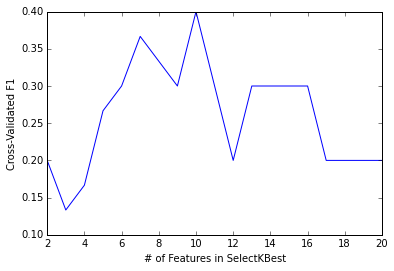

In [61]:
# Feature Selection for Linear SVM
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(f_range, lsvc_scores)
plt.xlabel('# of Features in SelectKBest')
plt.ylabel('Cross-Validated F1')